# Neural Iluminant experiment

In [6]:
from exp.nb_Tesis import *
from exp.NeuralIluminant import *

In [7]:
list(NeuralIluminant().parameters())

[Parameter containing:
 tensor([1., 1., 1.], device='cuda:0', requires_grad=True)]

In [8]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [9]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [10]:
# !unzip ISIC_2019_Training_Input.zip

In [11]:
min_dim = 128# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [12]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [14]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [15]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [16]:
!nvidia-smi

Mon Mar 30 21:28:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   39C    P2    55W / 250W |    395MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [18]:
# torch.cuda.set_device(0)

## Load the dataset

In [19]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

In [20]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

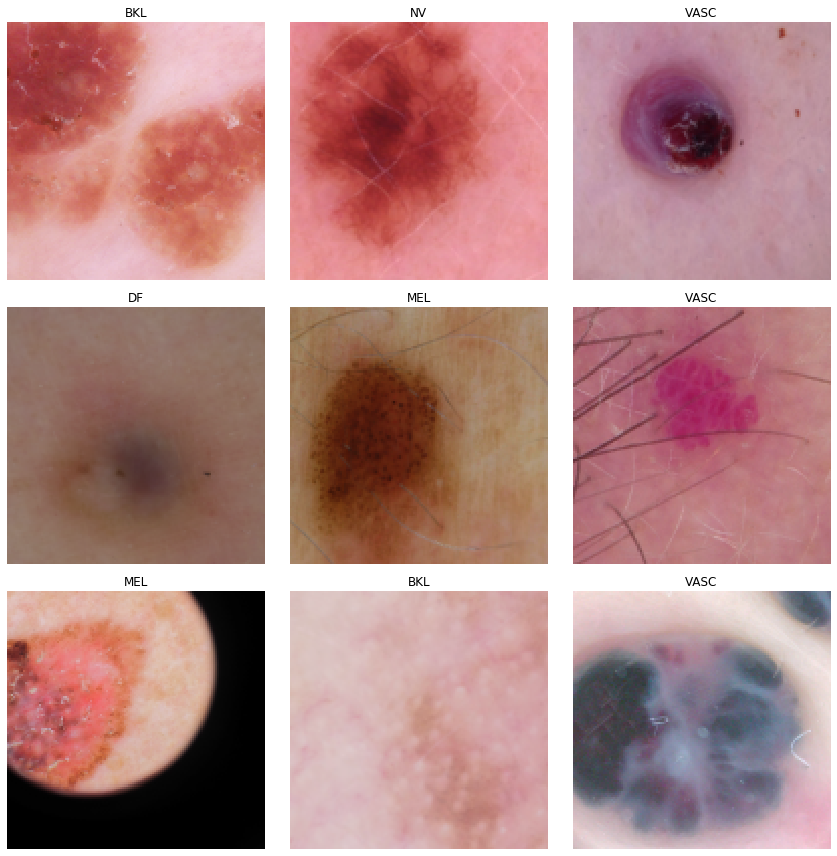

In [21]:
data.show_batch(3)

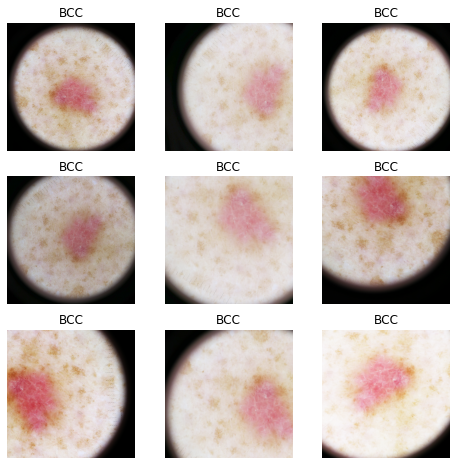

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [23]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 MEL     378
BCC     375
AK      375
NV      367
BKL     363
DF      197
VASC    195
dtype: int64 

 valid_count: 
 BKL     101
NV       97
BCC      89
AK       89
MEL      86
VASC     58
DF       42
dtype: int64
ratios:
AK      0.237333
BCC     0.237333
BKL     0.278237
DF      0.213198
MEL     0.227513
NV      0.264305
VASC    0.297436
dtype: float64 %


In [24]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True,seed=1):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(seed,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd
                          ,callbacks = [
                            SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
                            CSVLogger(learn=learner,filename=log_name),
                            ]
                         )

# Training

First let's see the baseline result
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True
* Efficientnet-b0

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64

### Without color correction

In [76]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [77]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_name(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                                ])

# learn_b0.summary()

[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.997012,1.944258,0.841637,0.158363,0.504347,00:13
1,1.929673,1.961358,0.820285,0.179715,0.566121,00:13
2,1.862906,1.841131,0.790036,0.209964,0.424591,00:13
3,1.742282,1.713689,0.711744,0.288256,0.496187,00:13
4,1.666956,1.613942,0.669039,0.330961,0.462337,00:13


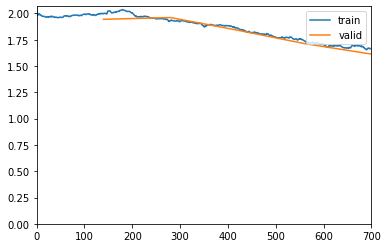

Better model found at epoch 0 with accuracy value: 0.1583629846572876.
Better model found at epoch 1 with accuracy value: 0.17971530556678772.
Better model found at epoch 2 with accuracy value: 0.20996440947055817.
Better model found at epoch 3 with accuracy value: 0.2882562279701233.
Better model found at epoch 4 with accuracy value: 0.33096083998680115.


In [32]:
train_learner(learn_b0,'EfficientNet-b0',epochs=5)

## With neural iluminant

### Neural Iluminant

In [25]:
from exp.NeuralIluminant import NeuralIluminant

In [39]:
list(NeuralIluminant().parameters())

[Parameter containing:
 tensor([1., 1., 1.], device='cuda:0', requires_grad=True)]

In [36]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0_with_NeuralIluminant = EfficientNet.from_name(model_name)
model_b0_with_NeuralIluminant._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

complete_model_b0_with_NeuralIluminant = nn.Sequential(NeuralIluminant(),model_b0_with_NeuralIluminant)
learn_b0_with_neural_iluminant = Learner(data,complete_model_b0_with_NeuralIluminant, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0_with_neural_iluminant.summary()

[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.997456,1.944264,0.841637,0.158363,0.469119,00:14


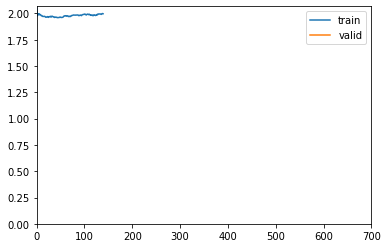

Better model found at epoch 0 with accuracy value: 0.1583629846572876.


RuntimeError: Could not infer dtype of NoneType

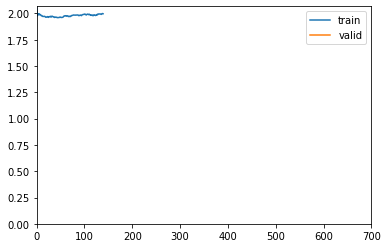

In [37]:
train_learner(learn_b0_with_neural_iluminant,'EfficientNet-b0',epochs=5)

In [152]:
learn_b0_with_neural_iluminant.model[0].iluminant

Parameter containing:
tensor([1.0170, 0.9858, 1.0039], device='cuda:0', requires_grad=True)

# Iterations

Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.811781,1.692295,0.612100,0.387900,0.502886,00:13
1,1.374064,1.208183,0.469751,0.530249,0.543222,00:13
2,1.207875,1.115550,0.439502,0.560498,0.600257,00:13
3,1.144294,1.115314,0.435943,0.564057,0.557926,00:13
4,1.137253,1.229508,0.475089,0.524911,0.645367,00:13
5,1.122904,1.553564,0.524911,0.475089,0.414329,00:13
6,1.125236,1.417420,0.469751,0.530249,0.688743,00:13
7,1.078668,1.122833,0.423488,0.576512,0.405991,00:13
8,1.003262,1.152632,0.434164,0.565836,0.428297,00:13
9,0.933260,1.080582,0.370107,0.629893,0.536950,00:13


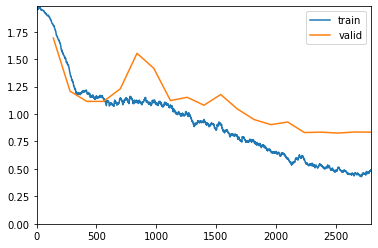

Better model found at epoch 0 with accuracy value: 0.38790035247802734.
Better model found at epoch 1 with accuracy value: 0.5302491188049316.
Better model found at epoch 2 with accuracy value: 0.5604982376098633.
Better model found at epoch 3 with accuracy value: 0.564056932926178.
Better model found at epoch 7 with accuracy value: 0.5765124559402466.
Better model found at epoch 9 with accuracy value: 0.6298932433128357.
Better model found at epoch 12 with accuracy value: 0.6352313160896301.
Better model found at epoch 13 with accuracy value: 0.6761565804481506.
Better model found at epoch 15 with accuracy value: 0.6868327260017395.
Better model found at epoch 18 with accuracy value: 0.6939501762390137.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.811784,1.692257,0.612100,0.387900,0.502791,00:13
1,1.373690,1.206532,0.467972,0.532028,0.542366,00:13
2,1.208982,1.119248,0.439502,0.560498,0.589638,00:13
3,1.137529,1.144006,0.466192,0.533808,0.570658,00:13
4,1.123359,1.483926,0.500000,0.500000,0.690691,00:13
5,1.101956,1.475939,0.530249,0.469751,0.486638,00:13
6,1.111667,1.205498,0.450178,0.549822,0.548566,00:13
7,1.067308,1.211290,0.421708,0.578292,0.473668,00:13
8,1.038162,1.108058,0.416370,0.583630,0.460722,00:13
9,0.933284,1.046586,0.370107,0.629893,0.492173,00:13


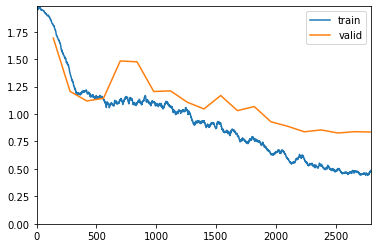

Better model found at epoch 0 with accuracy value: 0.38790035247802734.
Better model found at epoch 1 with accuracy value: 0.5320284962654114.
Better model found at epoch 2 with accuracy value: 0.5604982376098633.
Better model found at epoch 7 with accuracy value: 0.5782918334007263.
Better model found at epoch 8 with accuracy value: 0.5836299061775208.
Better model found at epoch 9 with accuracy value: 0.6298932433128357.
Better model found at epoch 13 with accuracy value: 0.6387900114059448.
Better model found at epoch 14 with accuracy value: 0.6619216799736023.
Better model found at epoch 15 with accuracy value: 0.6654804348945618.
Better model found at epoch 17 with accuracy value: 0.6797152757644653.
Parameter containing:
tensor([1.0158, 0.9946, 1.0005], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.814890,1.720101,0.640569,0.359431,0.500630,00:13
1,1.417047,1.231545,0.471530,0.528470,0.562772,00:13
2,1.171346,1.141958,0.439502,0.560498,0.539326,00:13
3,1.156792,1.321242,0.494662,0.505338,0.417417,00:13
4,1.149139,1.318238,0.464413,0.535587,0.432620,00:13
5,1.124141,1.509265,0.466192,0.533808,0.598380,00:13
6,1.058604,1.460381,0.466192,0.533808,0.681212,00:13
7,1.149402,1.285119,0.462633,0.537367,0.549160,00:13
8,0.975205,1.376087,0.503559,0.496441,0.355940,00:13
9,0.910759,1.219247,0.427046,0.572954,0.493527,00:13


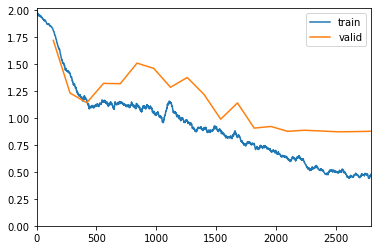

Better model found at epoch 0 with accuracy value: 0.35943061113357544.
Better model found at epoch 1 with accuracy value: 0.5284697413444519.
Better model found at epoch 2 with accuracy value: 0.5604982376098633.
Better model found at epoch 9 with accuracy value: 0.5729537606239319.
Better model found at epoch 10 with accuracy value: 0.6387900114059448.
Better model found at epoch 12 with accuracy value: 0.6476868391036987.
Better model found at epoch 14 with accuracy value: 0.6583629846572876.
Better model found at epoch 16 with accuracy value: 0.6672598123550415.
Better model found at epoch 17 with accuracy value: 0.6725978851318359.
Better model found at epoch 18 with accuracy value: 0.6779359579086304.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.801425,1.717078,0.637011,0.362989,0.493432,00:13
1,1.375395,1.223272,0.464413,0.535587,0.532152,00:13
2,1.204839,1.168258,0.487544,0.512456,0.590588,00:13
3,1.168525,1.050885,0.405694,0.594306,0.564363,00:13
4,1.155698,1.314326,0.467972,0.532028,0.537022,00:13
5,1.152157,1.523393,0.540925,0.459075,0.350785,00:13
6,1.110989,1.547622,0.471530,0.528470,0.591182,00:13
7,1.107255,1.242677,0.476868,0.523132,0.554933,00:13
8,1.038448,1.194537,0.421708,0.578292,0.554410,00:13
9,0.955337,1.145356,0.393238,0.606762,0.423997,00:13


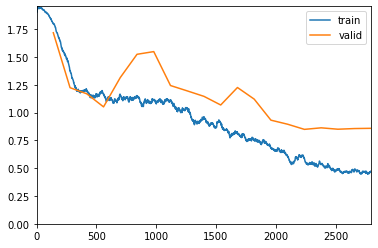

Better model found at epoch 0 with accuracy value: 0.3629893362522125.
Better model found at epoch 1 with accuracy value: 0.5355871915817261.
Better model found at epoch 3 with accuracy value: 0.5943060517311096.
Better model found at epoch 9 with accuracy value: 0.6067615747451782.
Better model found at epoch 13 with accuracy value: 0.6548042893409729.
Better model found at epoch 14 with accuracy value: 0.6868327260017395.
Better model found at epoch 17 with accuracy value: 0.6886121034622192.
Better model found at epoch 18 with accuracy value: 0.6921707987785339.
Parameter containing:
tensor([0.9973, 1.0023, 1.0023], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.825572,1.731518,0.610320,0.389680,0.427489,00:13
1,1.394451,1.187570,0.487544,0.512456,0.564767,00:13
2,1.187779,1.120271,0.434164,0.565836,0.512673,00:13
3,1.149109,1.312875,0.485765,0.514235,0.509466,00:13
4,1.121711,1.477786,0.476868,0.523132,0.424330,00:13
5,1.158743,1.477847,0.494662,0.505338,0.546642,00:13
6,1.078550,1.282744,0.475089,0.524911,0.549516,00:13
7,1.086888,1.281525,0.480427,0.519573,0.510987,00:13
8,1.000860,1.077951,0.405694,0.594306,0.585647,00:13
9,0.930332,1.155569,0.425267,0.574733,0.451505,00:13


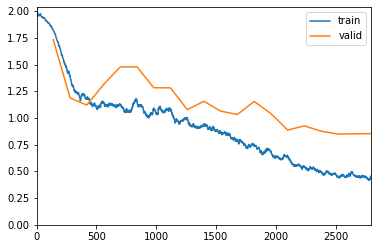

Better model found at epoch 0 with accuracy value: 0.3896797299385071.
Better model found at epoch 1 with accuracy value: 0.5124555230140686.
Better model found at epoch 2 with accuracy value: 0.5658363103866577.
Better model found at epoch 8 with accuracy value: 0.5943060517311096.
Better model found at epoch 10 with accuracy value: 0.6156583428382874.
Better model found at epoch 11 with accuracy value: 0.6192170977592468.
Better model found at epoch 13 with accuracy value: 0.6334519386291504.
Better model found at epoch 14 with accuracy value: 0.6797152757644653.
Better model found at epoch 17 with accuracy value: 0.6850534081459045.
Better model found at epoch 18 with accuracy value: 0.690391480922699.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.820464,1.739411,0.604982,0.395018,0.443048,00:13
1,1.388028,1.215301,0.446619,0.553381,0.524954,00:13
2,1.211609,1.185242,0.489324,0.510676,0.655462,00:13
3,1.162864,1.179722,0.473310,0.526690,0.466328,00:13
4,1.155217,1.237471,0.485765,0.514235,0.532675,00:13
5,1.163078,1.543470,0.524911,0.475089,0.538090,00:13
6,1.122803,1.414186,0.451957,0.548043,0.586883,00:13
7,1.097805,1.224168,0.441281,0.558719,0.442074,00:13
8,1.051792,1.407307,0.517794,0.482206,0.608689,00:13
9,0.935297,1.066677,0.423488,0.576512,0.528969,00:13


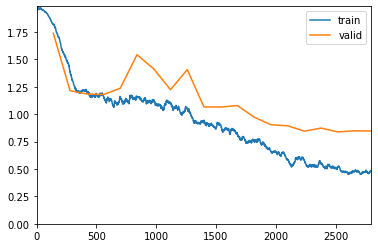

Better model found at epoch 0 with accuracy value: 0.3950178027153015.
Better model found at epoch 1 with accuracy value: 0.5533807873725891.
Better model found at epoch 7 with accuracy value: 0.5587188601493835.
Better model found at epoch 9 with accuracy value: 0.5765124559402466.
Better model found at epoch 10 with accuracy value: 0.5854092240333557.
Better model found at epoch 11 with accuracy value: 0.6174377202987671.
Better model found at epoch 12 with accuracy value: 0.6405693888664246.
Better model found at epoch 13 with accuracy value: 0.6654804348945618.
Better model found at epoch 14 with accuracy value: 0.6690391302108765.
Better model found at epoch 17 with accuracy value: 0.6797152757644653.
Better model found at epoch 18 with accuracy value: 0.690391480922699.
Better model found at epoch 19 with accuracy value: 0.6939501762390137.
Parameter containing:
tensor([1.0170, 0.9931, 1.0002], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.809235,1.709953,0.619217,0.380783,0.487422,00:13
1,1.389420,1.246858,0.498221,0.501779,0.556263,00:13
2,1.180677,1.169430,0.462633,0.537367,0.581989,00:13
3,1.133720,1.376506,0.507117,0.492883,0.526522,00:13
4,1.138946,1.368617,0.523132,0.476868,0.638216,00:13
5,1.154443,1.384841,0.500000,0.500000,0.514977,00:13
6,1.099411,1.485508,0.494662,0.505338,0.523458,00:13
7,1.031216,1.445536,0.476868,0.523132,0.638953,00:13
8,0.987760,1.153079,0.432384,0.567616,0.436207,00:13
9,0.955046,1.232163,0.450178,0.549822,0.626054,00:13


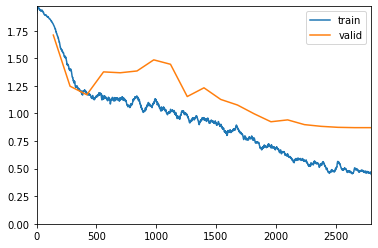

Better model found at epoch 0 with accuracy value: 0.38078293204307556.
Better model found at epoch 1 with accuracy value: 0.5017793774604797.
Better model found at epoch 2 with accuracy value: 0.5373665690422058.
Better model found at epoch 8 with accuracy value: 0.5676156878471375.
Better model found at epoch 10 with accuracy value: 0.599644124507904.
Better model found at epoch 11 with accuracy value: 0.6014235019683838.
Better model found at epoch 12 with accuracy value: 0.6370106935501099.
Better model found at epoch 14 with accuracy value: 0.6512455344200134.
Better model found at epoch 16 with accuracy value: 0.6743772029876709.
Better model found at epoch 17 with accuracy value: 0.6850534081459045.
Better model found at epoch 18 with accuracy value: 0.6868327260017395.
Better model found at epoch 19 with accuracy value: 0.6886121034622192.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 4

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.814209,1.706340,0.617438,0.382562,0.484666,00:13
1,1.373374,1.248044,0.464413,0.535587,0.558804,00:13
2,1.183313,1.104683,0.455516,0.544484,0.653301,00:13
3,1.144079,1.265110,0.491103,0.508897,0.543578,00:13
4,1.130992,1.296506,0.475089,0.524911,0.553531,00:13
5,1.105260,2.018592,0.592527,0.407473,0.447870,00:13
6,1.150260,1.366432,0.453737,0.546263,0.611184,00:13
7,1.078122,1.207315,0.462633,0.537367,0.559185,00:13
8,1.035273,1.212966,0.457295,0.542705,0.595767,00:13
9,0.954711,1.043183,0.387900,0.612100,0.486496,00:13


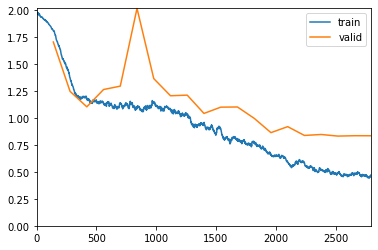

Better model found at epoch 0 with accuracy value: 0.3825622797012329.
Better model found at epoch 1 with accuracy value: 0.5355871915817261.
Better model found at epoch 2 with accuracy value: 0.5444839596748352.
Better model found at epoch 6 with accuracy value: 0.5462633371353149.
Better model found at epoch 9 with accuracy value: 0.6120996475219727.
Better model found at epoch 13 with accuracy value: 0.6619216799736023.
Better model found at epoch 14 with accuracy value: 0.6654804348945618.
Better model found at epoch 15 with accuracy value: 0.6886121034622192.
Parameter containing:
tensor([1.0228, 0.9910, 1.0003], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.815631,1.709207,0.622776,0.377224,0.501295,00:13
1,1.374293,1.249677,0.494662,0.505338,0.509894,00:13
2,1.121000,1.201191,0.467972,0.532028,0.440744,00:13
3,1.111066,1.166695,0.443060,0.556939,0.452075,00:13
4,1.115545,1.356740,0.457295,0.542705,0.508635,00:13
5,1.126126,1.519728,0.494662,0.505338,0.342542,00:13
6,1.067251,1.533502,0.526690,0.473310,0.402570,00:13
7,0.993238,1.223565,0.409253,0.590747,0.446231,00:13
8,0.995786,1.099992,0.437722,0.562278,0.594104,00:13
9,0.990194,1.093292,0.403915,0.596085,0.565052,00:13


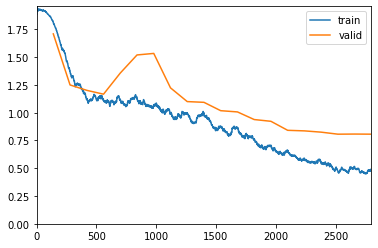

Better model found at epoch 0 with accuracy value: 0.3772242069244385.
Better model found at epoch 1 with accuracy value: 0.5053380727767944.
Better model found at epoch 2 with accuracy value: 0.5320284962654114.
Better model found at epoch 3 with accuracy value: 0.5569394826889038.
Better model found at epoch 7 with accuracy value: 0.5907473564147949.
Better model found at epoch 9 with accuracy value: 0.5960854291915894.
Better model found at epoch 10 with accuracy value: 0.6245551705360413.
Better model found at epoch 13 with accuracy value: 0.6548042893409729.
Better model found at epoch 15 with accuracy value: 0.6868327260017395.
Better model found at epoch 17 with accuracy value: 0.6939501762390137.
Better model found at epoch 18 with accuracy value: 0.7046263217926025.
Better model found at epoch 19 with accuracy value: 0.7064056992530823.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.809103,1.713782,0.631673,0.368327,0.501508,00:13
1,1.377030,1.214659,0.471530,0.528470,0.567784,00:13
2,1.185069,1.136882,0.435943,0.564057,0.674490,00:13
3,1.148503,1.236150,0.496441,0.503559,0.479203,00:13
4,1.157242,1.328557,0.491103,0.508897,0.666508,00:13
5,1.128824,1.649910,0.540925,0.459075,0.508065,00:13
6,1.113153,1.465224,0.485765,0.514235,0.599710,00:13
7,1.059171,1.228324,0.464413,0.535587,0.573533,00:13
8,1.007079,1.144013,0.451957,0.548043,0.547022,00:13
9,0.932080,1.012397,0.393238,0.606762,0.627004,00:14


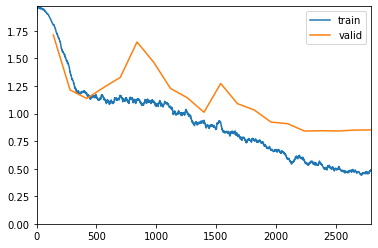

Better model found at epoch 0 with accuracy value: 0.36832740902900696.
Better model found at epoch 1 with accuracy value: 0.5284697413444519.
Better model found at epoch 2 with accuracy value: 0.564056932926178.
Better model found at epoch 9 with accuracy value: 0.6067615747451782.
Better model found at epoch 12 with accuracy value: 0.6192170977592468.
Better model found at epoch 13 with accuracy value: 0.6548042893409729.
Better model found at epoch 14 with accuracy value: 0.6761565804481506.
Better model found at epoch 15 with accuracy value: 0.6850534081459045.
Better model found at epoch 16 with accuracy value: 0.6957295536994934.
Better model found at epoch 17 with accuracy value: 0.7064056992530823.
Parameter containing:
tensor([1.0339, 0.9910, 0.9922], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VAS

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.811104,1.708563,0.629893,0.370107,0.514146,00:13
1,1.400175,1.161517,0.466192,0.533808,0.584388,00:13
2,1.148765,1.188841,0.466192,0.533808,0.584578,00:13
3,1.171155,1.131017,0.432384,0.567616,0.548923,00:13
4,1.144931,1.351237,0.482206,0.517794,0.583985,00:13
5,1.156553,1.267296,0.478648,0.521352,0.578474,00:13
6,1.101563,1.176390,0.414591,0.585409,0.533055,00:13
7,1.052071,1.216559,0.466192,0.533808,0.423356,00:13
8,0.987434,1.164061,0.434164,0.565836,0.427869,00:13
9,0.948912,1.271036,0.414591,0.585409,0.553982,00:13


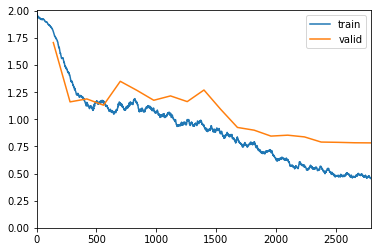

Better model found at epoch 0 with accuracy value: 0.3701067566871643.
Better model found at epoch 1 with accuracy value: 0.5338078141212463.
Better model found at epoch 3 with accuracy value: 0.5676156878471375.
Better model found at epoch 6 with accuracy value: 0.5854092240333557.
Better model found at epoch 10 with accuracy value: 0.6067615747451782.
Better model found at epoch 11 with accuracy value: 0.6352313160896301.
Better model found at epoch 13 with accuracy value: 0.6583629846572876.
Better model found at epoch 14 with accuracy value: 0.6619216799736023.
Better model found at epoch 16 with accuracy value: 0.6939501762390137.
Better model found at epoch 18 with accuracy value: 0.6957295536994934.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.807471,1.703382,0.644128,0.355872,0.493099,00:13
1,1.371384,1.219615,0.462633,0.537367,0.584246,00:13
2,1.197127,1.149297,0.471530,0.528470,0.533767,00:13
3,1.151491,1.191169,0.462633,0.537367,0.492482,00:13
4,1.151242,1.402395,0.489324,0.510676,0.606884,00:13
5,1.130014,1.390846,0.460854,0.539146,0.412025,00:13
6,1.148479,1.234381,0.443060,0.556939,0.651163,00:13
7,1.088635,1.167045,0.412811,0.587189,0.321781,00:13
8,1.015254,1.183465,0.435943,0.564057,0.521652,00:13
9,0.948215,1.185266,0.439502,0.560498,0.465354,00:13


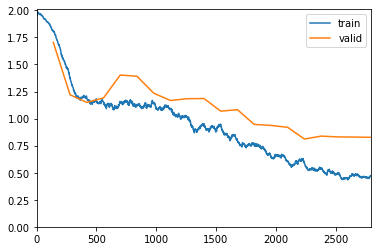

Better model found at epoch 0 with accuracy value: 0.35587188601493835.
Better model found at epoch 1 with accuracy value: 0.5373665690422058.
Better model found at epoch 5 with accuracy value: 0.5391458868980408.
Better model found at epoch 6 with accuracy value: 0.5569394826889038.
Better model found at epoch 7 with accuracy value: 0.5871886014938354.
Better model found at epoch 10 with accuracy value: 0.5960854291915894.
Better model found at epoch 12 with accuracy value: 0.6530249118804932.
Better model found at epoch 14 with accuracy value: 0.6743772029876709.
Better model found at epoch 15 with accuracy value: 0.708185076713562.
Better model found at epoch 16 with accuracy value: 0.709964394569397.
Parameter containing:
tensor([1.0187, 1.0003, 0.9889], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC'

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.788561,1.683057,0.615658,0.384342,0.466898,00:13
1,1.359855,1.228694,0.492883,0.507117,0.493171,00:13
2,1.189536,1.181789,0.457295,0.542705,0.577618,00:13
3,1.140517,1.463496,0.475089,0.524911,0.471079,00:13
4,1.166040,1.259554,0.460854,0.539146,0.465188,00:13
5,1.111890,1.583251,0.501779,0.498221,0.621968,00:13
6,1.063183,1.120673,0.412811,0.587189,0.544647,00:13
7,1.010735,1.119217,0.437722,0.562278,0.500535,00:13
8,1.013399,1.167713,0.409253,0.590747,0.697650,00:13
9,0.935246,1.637892,0.562278,0.437722,0.446208,00:13


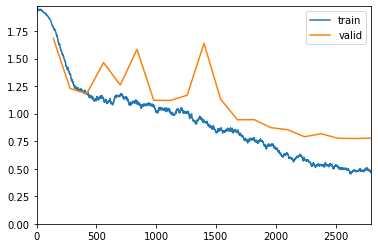

Better model found at epoch 0 with accuracy value: 0.38434162735939026.
Better model found at epoch 1 with accuracy value: 0.5071174502372742.
Better model found at epoch 2 with accuracy value: 0.5427046418190002.
Better model found at epoch 6 with accuracy value: 0.5871886014938354.
Better model found at epoch 8 with accuracy value: 0.5907473564147949.
Better model found at epoch 10 with accuracy value: 0.6103202700614929.
Better model found at epoch 11 with accuracy value: 0.6334519386291504.
Better model found at epoch 12 with accuracy value: 0.6672598123550415.
Better model found at epoch 13 with accuracy value: 0.6939501762390137.
Better model found at epoch 15 with accuracy value: 0.6992882490158081.
Better model found at epoch 18 with accuracy value: 0.7046263217926025.
Better model found at epoch 19 with accuracy value: 0.708185076713562.
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.790916,1.677878,0.613879,0.386121,0.489774,00:13
1,1.368999,1.208361,0.473310,0.526690,0.555146,00:13
2,1.178998,1.170553,0.480427,0.519573,0.598403,00:13
3,1.123976,1.270087,0.444840,0.555160,0.532057,00:13
4,1.125752,1.326403,0.496441,0.503559,0.580778,00:13
5,1.122275,2.083854,0.567616,0.432384,0.448583,00:13
6,1.095062,1.474595,0.469751,0.530249,0.628762,00:13
7,1.071393,1.113118,0.393238,0.606762,0.496282,00:13
8,1.034697,1.108704,0.428826,0.571174,0.513219,00:13
9,0.964347,1.151312,0.403915,0.596085,0.504026,00:13


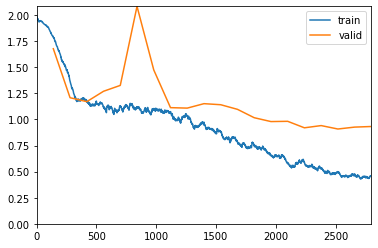

Better model found at epoch 0 with accuracy value: 0.38612100481987.
Better model found at epoch 1 with accuracy value: 0.5266903638839722.
Better model found at epoch 3 with accuracy value: 0.5551601648330688.
Better model found at epoch 7 with accuracy value: 0.6067615747451782.
Better model found at epoch 12 with accuracy value: 0.6298932433128357.
Better model found at epoch 13 with accuracy value: 0.6387900114059448.
Better model found at epoch 14 with accuracy value: 0.6423487663269043.
Better model found at epoch 16 with accuracy value: 0.6441280841827393.
Better model found at epoch 17 with accuracy value: 0.663701057434082.
Parameter containing:
tensor([1.0154, 0.9969, 0.9957], device='cuda:0', requires_grad=True)
Loaded pretrained weights for efficientnet-b0
[{'AK': 42.0}, {'BCC': 42.0}, {'BKL': 43.388429752066116}, {'DF': 79.9492385786802}, {'MEL': 41.66666666666667}, {'NV': 42.915531335149865}, {'VASC': 80.76923076923077}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.812747,1.717882,0.647687,0.352313,0.490201,00:13
1,1.420948,1.222284,0.487544,0.512456,0.574578,00:13
2,1.185623,1.125976,0.453737,0.546263,0.567760,00:13
3,1.120753,1.284575,0.485765,0.514235,0.427465,00:13
4,1.103280,1.467298,0.508897,0.491103,0.638169,00:13
5,1.098349,1.609908,0.475089,0.524911,0.633347,00:13
6,1.114446,1.342763,0.471530,0.528470,0.466447,00:13
7,1.079906,1.252398,0.462633,0.537367,0.573295,00:13
8,0.987741,1.156846,0.412811,0.587189,0.401976,00:13


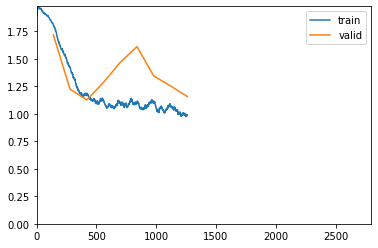

Better model found at epoch 0 with accuracy value: 0.35231316089630127.
Better model found at epoch 1 with accuracy value: 0.5124555230140686.
Better model found at epoch 2 with accuracy value: 0.5462633371353149.
Better model found at epoch 8 with accuracy value: 0.5871886014938354.


KeyboardInterrupt: 

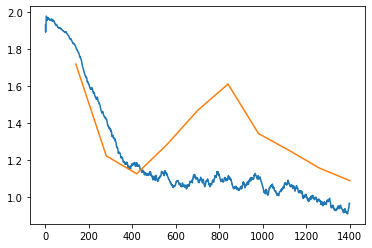

In [40]:
from efficientnet_pytorch import EfficientNet
seeds = [1,2,3,4,5,6,7,8]
epochs = 20
images_folder = 'picked_30_ISIC_2019_Training_Input'

for s in seeds:
    data = reload_dataset(images_folder)
    random_seed(s,True)

    model_name = 'efficientnet-b0'
    model_b0 = EfficientNet.from_pretrained(model_name)
    model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

    learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph
                                ])

    # learn_b0.summary()


    train_learner(learn_b0,'EfficientNet-b0',epochs=epochs, seed=s)
    l1 = list(map(lambda x: x[1], learn_b0.recorder.metrics))
    
    
    
    
    #Con color correction
    
    
    data = reload_dataset(destFolder)

    # Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion

    random_seed(s,True)

    model_name = 'efficientnet-b0'
    model_b0_with_NeuralIluminant = EfficientNet.from_pretrained(model_name)
    model_b0_with_NeuralIluminant._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

    complete_model_b0_with_NeuralIluminant = nn.Sequential(NeuralIluminant(),model_b0_with_NeuralIluminant)

    learn_b0_with_neural_iluminant = Learner(data,complete_model_b0_with_NeuralIluminant, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph
                                ])

    # learn_b0.summary()
    train_learner(learn_b0_with_neural_iluminant,'EfficientNet-b0',epochs=epochs, seed=1)
    
    l2 = list(map(lambda x: x[1], learn_b0_with_neural_iluminant.recorder.metrics))
    print(learn_b0_with_neural_iluminant.model[0].iluminant)
    f = open(f'neural_iluminant_run_seed_{s}.txt','w+')
    f.write('Baseline,Neural_Iluminant\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()